# Tutorial - explanation wrappers for pytorch

This notebook shows how to use the wrappers around different explanation libraries built into quantus. 

For this purpose, we use a pre-trained ResNet-18 model and ImageNet dataset. A description for how to download the dataset can be found here: https://image-net.org/download.php.


- Make sure to have GPUs enabled to speed up computation.
- Skip running the first cell if you do not use Google Colab.

## 1. Preliminaries

In [22]:
# Imports general.
import sys
import gc
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import os
import cv2
from PIL import Image
import json

# Import package.
path = "../"
sys.path.append(f'{path}/quantus')
import quantus

# Some paths
datapath = "assets/xai_wrapper_tutorial/samples"
labelmappath = "assets/xai_wrapper_tutorial/label-map-imagenet.json"
classmappath = "assets/xai_wrapper_tutorial/wnidmapping.json"

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

# Configs torch (read more on this cuda-related issue here: https://github.com/pytorch/pytorch/issues/45769).
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.1 Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [23]:
def load_sample(path: str) -> dict:
    """Read data as image and path. """
    return {"input": PIL.Image.open(path).convert("RGB"), "path": path}

class ImageNet(torch.utils.data.Dataset):
    """ImageNet dataset."""

    def __init__(self, root_path, class_map_path, label_map_path, transform=None):
        self.root_path = root_path
        self.transform = transform
        self.label_map_path = label_map_path
        self.class_map_path = class_map_path

        self.samples = []

        # Loads the label map into memory
        with open(self.label_map_path) as label_map_file:
            # label map should have form {wnid: {"label": label, "name": name}, ...}
            self.label_map = json.load(label_map_file)

        with open(self.class_map_path) as class_map_file:
            # label map should have form {wnid: {"label": label, "name": name}, ...}
            self.class_map = json.load(class_map_file)


        files = os.listdir(root_path)
        files.sort()
        for name in files:
            nm = os.path.join(self.root_path, name)
            # print(nm)
            self.samples.append((nm, self.class_map[name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        path, wnid = self.samples[idx]
        sample = cv2.imread(path, cv2.IMREAD_COLOR)[:, :, ::-1]
        sample = Image.fromarray(sample)

        if self.transform:
            sample = self.transform(sample)

        return sample, torch.from_numpy(np.array(self.label_from_wnid(wnid)))

    def wnid_from_name(self, name):
        for wnid in self.label_map.keys():
            if self.label_map[wnid]["name"] == name:
                return wnid

    def wnid_from_label(self, label):
        for wnid in self.label_map.keys():
            if self.label_map[wnid]["label"] == label:
                return wnid

    def name_from_wnid(self, wnid):
        return self.label_map[wnid]["name"]

    def name_from_label(self, label):
        for wnid in self.label_map.keys():
            if self.label_map[wnid]["label"] == label:
                return self.label_map[wnid]["name"]

    def label_from_wnid(self, wnid):
        return self.label_map[wnid]["label"]

    def label_from_name(self, name):
        for wnid in self.label_map.keys():
            if self.label_map[wnid]["name"] == name:
                return self.label_map[wnid]["label"]


In [35]:
# Load test data and make loaders.
dataset = ImageNet(
    datapath,
    classmappath,
    labelmappath,
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
    )
)
test_loader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=24)

# Load a batch of inputs, segmentation masks and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)


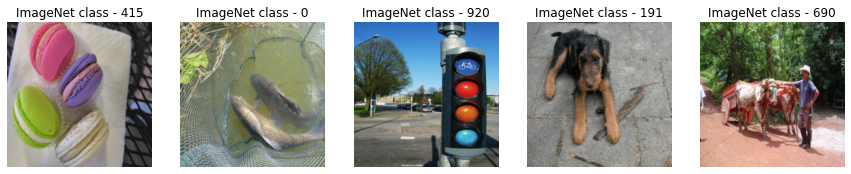

In [25]:
# Plot some inputs!

nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for i in range(nr_images):
    axes[i].imshow((np.moveaxis(quantus.denormalise(x_batch[i].cpu().numpy()), 0, -1) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"ImageNet class - {y_batch[i].item()}")
    axes[i].axis("off")
plt.show()

### 1.2 Load a pre-trained model

In this example we load a pre-trained ResNet-18 model but it goes without saying that any model works.

In [26]:
# Load pre-trained ResNet18 model.
model = torchvision.models.resnet18(pretrained=True)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/fe/lweber/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


### 2. Generate attribution-based explanations

While quantus accepts pre-computed explanations, several wrappers around existing XAI libraries are also provided. 
How to use the wrapped libraries will be showcased below.
Quantus detects installed explanation libraries automatically, and uses the appropriate wrappers. However, if multiple ones are installed, for pytorch, the default is to use *captum*.

**Requirements.**

* **Data type.** Similar to the x-y pairs, the attributions should also be of type `np.ndarray`
* **Shape.** Sharing all the same dimensions as the input (expect for nr_channels which for explanations is equal to 1). For example, if x_batch is of size (128, 3, 224, 224) then the attributions should be of size (128, 1, 224, 224).

### 2.1 Captum

In [36]:
# Define the XAI method that should be used to generate explanations
# For the captum wrapper, this is a string.

# E.g., parameters for generating IntegratedGradient explanations look like this
method = "IntegratedGradients" # String defining the XAI method

In [43]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch = quantus.explain(
    model, 
    x_batch, 
    y_batch, 
    method=method, 
    normalise=True
)

# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch_tmp, y_batch_tmp = x_batch.cpu().numpy(), y_batch.cpu().numpy()

# Quick assert.
assert [isinstance(obj, np.ndarray) for obj in [x_batch_tmp, y_batch_tmp, a_batch]]

Visualize attributions given model and pairs of input-output.

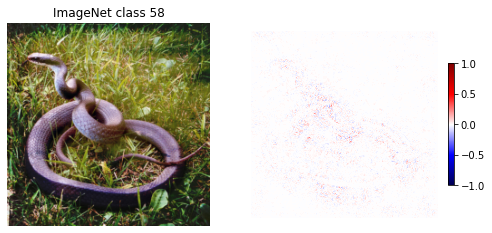

In [44]:
index = 5

# Plot examplary explanations!
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
axes[0].imshow(np.moveaxis(quantus.denormalise(x_batch_tmp[index], **{"img_size": 224}), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"ImageNet class {y_batch_tmp[index].item()}")
exp = axes[1].imshow(a_batch[index], cmap="seismic", vmin=-1.0, vmax=1.0) 
fig.colorbar(exp, fraction=0.03, pad=0.05); 
axes[0].axis("off"); axes[1].axis("off"); plt.show()

### 2.2. Zennit

In [45]:
# Additional Imports are needed
from zennit import canonizers as zcanon
from zennit import composites as zcomp
from zennit import attribution as zattr
from zennit import core as zcore
from zennit import torchvision as ztv

In [46]:
# Define the XAI method that should be used to generate explanations
# For the zennit wrapper, this is defined through a triple of canonizer, composite, and attributor.

# E.g., parameters for generating IntegratedGradient explanations look like this
canonizer = None # canonizer can be a zennit.canonizers.Canonizer subclass or None
composite = None # composite can be a zennit.core.Composite subclass, a string mapping to a composite, or None
attributor = zattr.IntegratedGradients # attributor can be any zennit.attribution.Attributor subclass

# In case both captum and zennit are installed, this kwarg also needs to be set to "zennit"
xai_lib = "zennit"

In [47]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch = quantus.explain(
    model, 
    x_batch, 
    y_batch, 
    canonizer=canonizer,
    composite=composite,
    attributor=attributor,
    normalise=True
)

# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch_tmp, y_batch_tmp = x_batch.cpu().numpy(), y_batch.cpu().numpy()

# Quick assert.
assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, a_batch]]

Visualize attributions given model and paris of input-output.

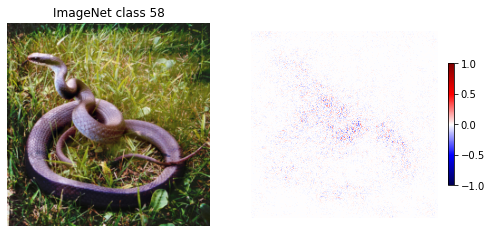

In [48]:
index = 5

# Plot examplary explanations!
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
axes[0].imshow(np.moveaxis(quantus.denormalise(x_batch_tmp[index], **{"img_size": 224}), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"ImageNet class {y_batch_tmp[index].item()}")
exp = axes[1].imshow(a_batch[index], cmap="seismic", vmin=-1.0, vmax=1.0) 
fig.colorbar(exp, fraction=0.03, pad=0.05); 
axes[0].axis("off"); axes[1].axis("off"); plt.show()